In [1]:
from operator import indexOf
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from scipy.constants import Boltzmann, epsilon_0, elementary_charge
import copy

start_time = time.time()
epsilon_r = 79
a = 23 * 10 ** (-6)
alpha = elementary_charge ** 2  /(4 * np.pi * epsilon_0 * epsilon_r * a**2)

            

In [2]:
##Oppgave 1a)
def createSystemOfMonomers(M, N):
    coordinates = [(x,y) for x in range(N) for y in range(N)]           #Lager liste med alle koordinatene i griden på liste form

    locations = random.sample(coordinates, 2*M)                        #velger 2 * M forskjellige slike koordinater

    grid = np.zeros(shape=(N,N))                                        #Lager så griden som NxN matrise
    #print(grid)
    distinctValues = list(range(-M, M+1))                             #Lager liste over distinkte verdier fra -M til M+1 og fjerner 0
    distinctValues.remove(0)
    random.shuffle(distinctValues)                                      #Stokker disse verdiene tilfeldig om

    for i in range(2*M):                                                #Setter hver tilfeldige verdi for monomer i griden lik en tilfeldigverdi
        grid[locations[i][0]][locations[i][1]] = distinctValues[i]
    return grid, locations                                              #Returnerer både girden og lokasjonen av monomerene

grid, locations = createSystemOfMonomers(15, 20)



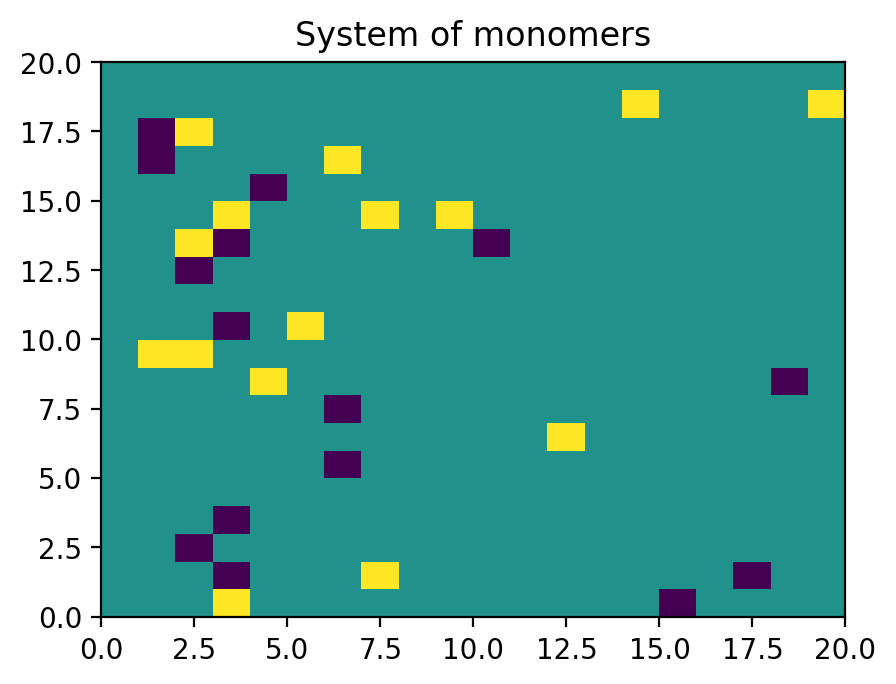

In [3]:
##Oppgave 1b) 
def plotSystemOfMonomers(grid, title, cluster = False): 
    if cluster == True:  
        plt.pcolormesh(grid[::-1], cmap= "Set1")
    else:                                            
        plt.pcolormesh(grid[::-1], vmin= -1, vmax= 1)                                          #Plotter en grid med pcolormesh
    
    plt.title(title)
    plt.show()

plotSystemOfMonomers(grid, "System of monomers")



In [4]:
##Oppgave 1c)
def findNeighbours(N, i, j):                                               #Denne funksjonen finner naboene til en gitt koordinat i griden
    neighbours = list()
    above = [(i - 1) % N, j]
    belove = [(i + 1) % N, j]
    left = [i, (j - 1) % N]
    right = [i, (j + 1) % N]
    
    neighbours.extend((above, belove, left, right))
    return neighbours

In [5]:
##Oppgave 1d)
def totalEnergy(grid):                                      #Finner total energi
    energy = 0
                                                            #nonzero gir ut x og y koordinatene respektivt til monomerene
    non_zero_indexes = np.nonzero(grid)  

    x_values = non_zero_indexes[0]
    y_values = non_zero_indexes[1]   

    for i in range(len(non_zero_indexes[0])):

        neighbours =  findNeighbours(np.shape(grid)[0], x_values[i], y_values[i])

        for j in range(len(x_values)):
            if [x_values[j], y_values[j]] in neighbours:
                energy += np.sign(grid[x_values[i]][y_values[i]] * grid[x_values[j]][y_values[j]])
    return energy * alpha / 2 #Dele på to for å ikke få overlapp

In [6]:
##Oppgave 1e)
def newLocationOfMonomer(direction, i, j, N):
    if direction == "left":
        return [(i - 1) % N, j] 
    if direction == "right":
        return [(i + 1) % N, j] 
    if direction == "up":
        return [i, (j + 1) % N] 
    if direction == "down":
        return [i, (j - 1) % N]

def MC(N_s, N, M, T):
    grid, locations = createSystemOfMonomers(M, N)

    initialGrid = copy.copy(grid)

    epsilon = np.zeros(N_s)

    EnergyOfState = totalEnergy(grid)

    directions = ["left", "right", "up", "down"]

    epsilon[0] = EnergyOfState

    for i in range(N_s):
        choosenMonomer = random.randint(0, len(locations)-1)         #Velger indexen i array av x og y verdier som gir pos til monomer
        x_val = locations[choosenMonomer][0]
        y_val = locations[choosenMonomer][1]
        
        valueOfChoosenMonomer = grid[x_val][y_val]

        neighbouringLocations = findNeighbours(N, x_val, y_val) 
        neighbouringMonomers = list()
        
        for location in neighbouringLocations:
            if tuple(location) in locations:
                neighbouringMonomers.append(location)

        direction = directions[random.randint(0, len(directions) - 1)]
        
        newLocation = newLocationOfMonomer(direction, x_val, y_val, N)
    
        if newLocation not in neighbouringMonomers:
            oldGrid = copy.copy(grid)
            grid[x_val][y_val] = 0
            grid[newLocation[0]][newLocation[1]] = valueOfChoosenMonomer

            EnergyOfState_new = totalEnergy(grid)

            if EnergyOfState_new < EnergyOfState:
                EnergyOfState = copy.copy(EnergyOfState_new) 
                locations.remove((x_val, y_val))
                locations.append((newLocation[0], newLocation[1]))
                   
            elif random.random() < np.exp(- (1 / (Boltzmann * T)) * (EnergyOfState_new - EnergyOfState)):  
                EnergyOfState = copy.copy(EnergyOfState_new)
                locations.remove((x_val, y_val))
                locations.append((newLocation[0], newLocation[1]))

            else:
                grid = copy.copy(oldGrid)
                
        epsilon[i] = EnergyOfState
    
    return grid, epsilon, initialGrid

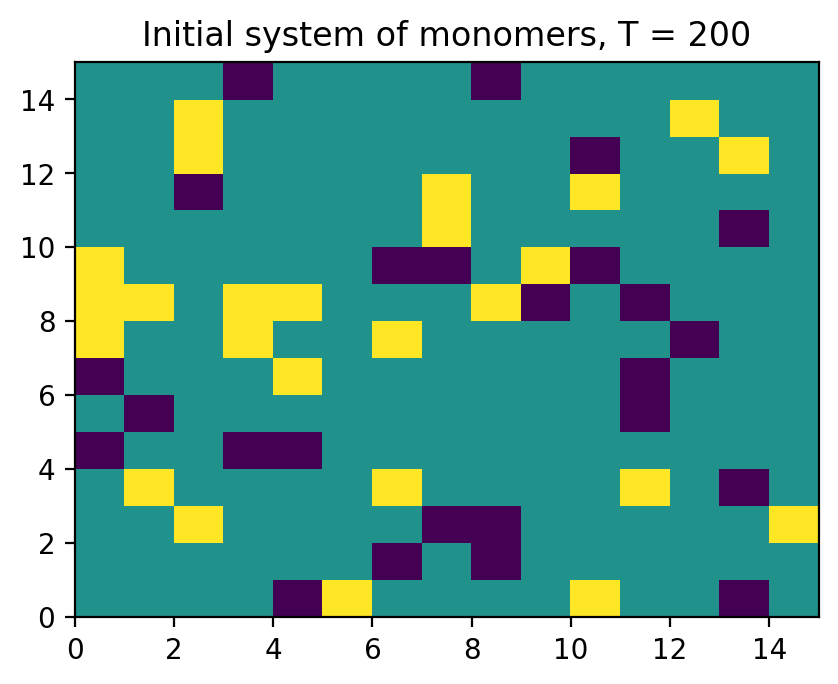

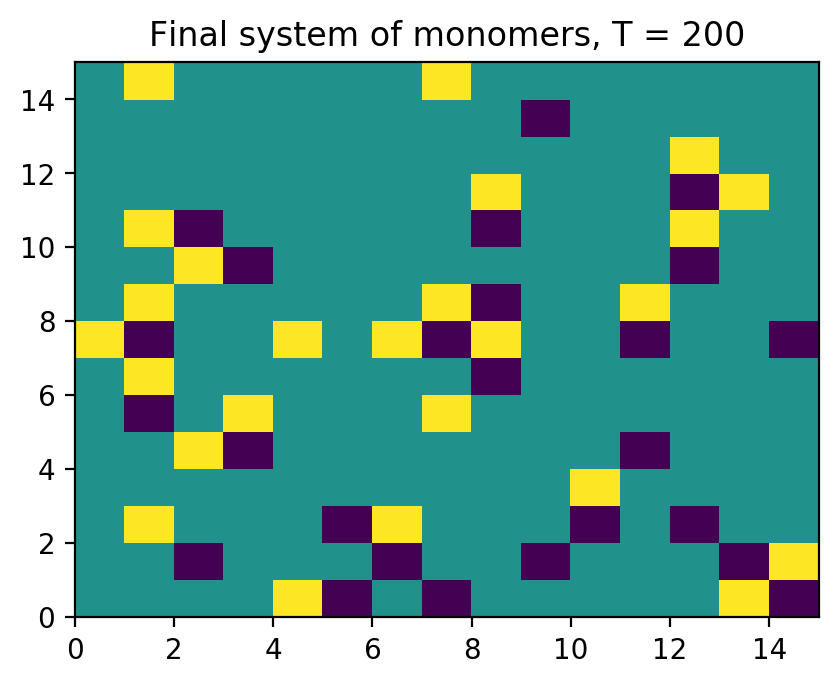

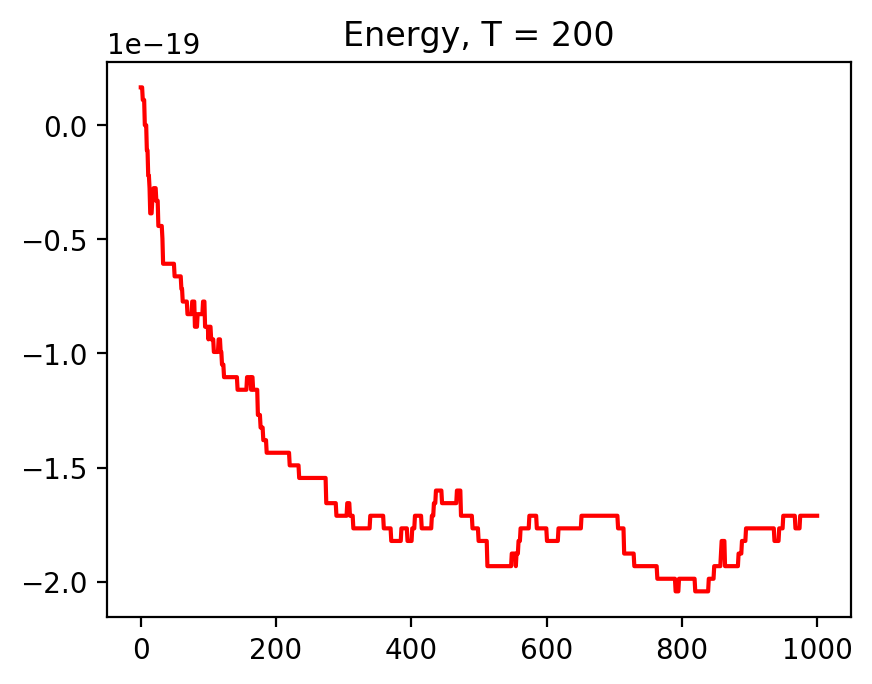

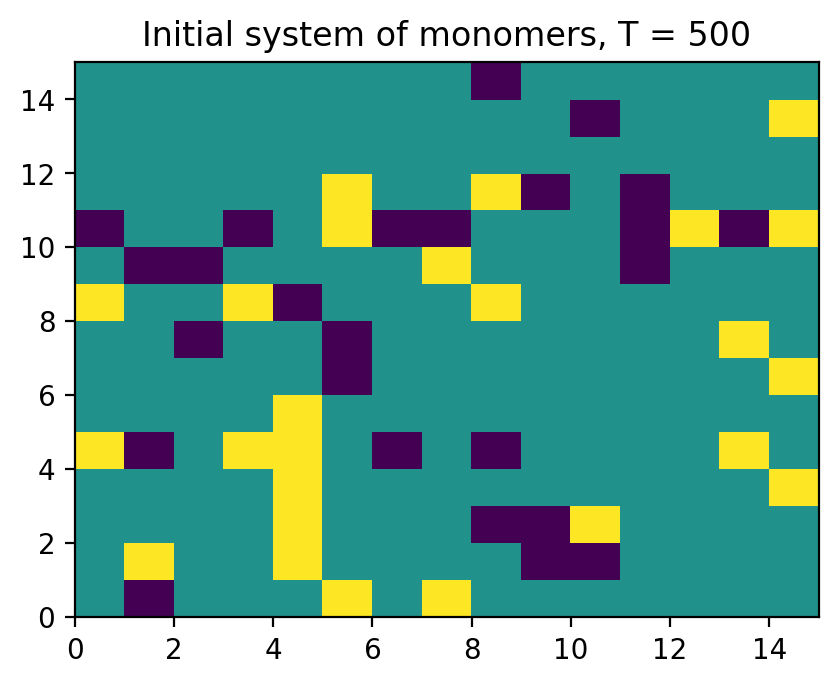

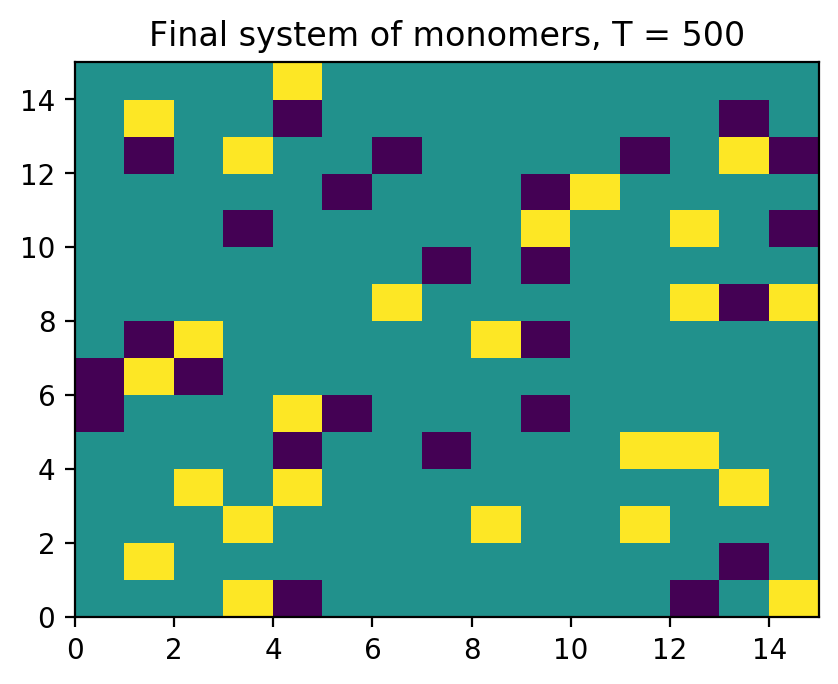

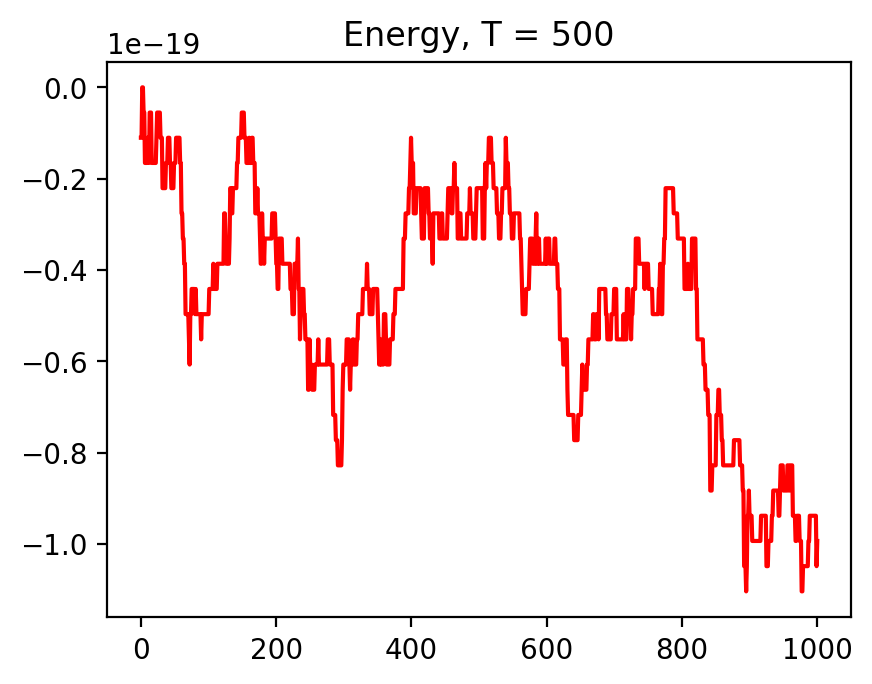

In [7]:
def plotEnergy(epsilon, title):
    t = np.linspace(0, len(epsilon), len(epsilon))

    plt.title(title)
    plt.plot(t, epsilon, "r")
    plt.show()

grid_200, epsilon_200, initialGrid_200 = MC(1000, 15, 25, 200)

plotSystemOfMonomers(initialGrid_200, "Initial system of monomers, T = 200")
plotSystemOfMonomers(grid_200, "Final system of monomers, T = 200")

plotEnergy(epsilon_200, "Energy, T = 200")

grid_500, epsilon_500, initialGrid_500 = MC(1000, 15, 25, 500)

plotSystemOfMonomers(initialGrid_500, "Initial system of monomers, T = 500")
plotSystemOfMonomers(grid_500, "Final system of monomers, T = 500")

plotEnergy(epsilon_500, "Energy, T = 500")


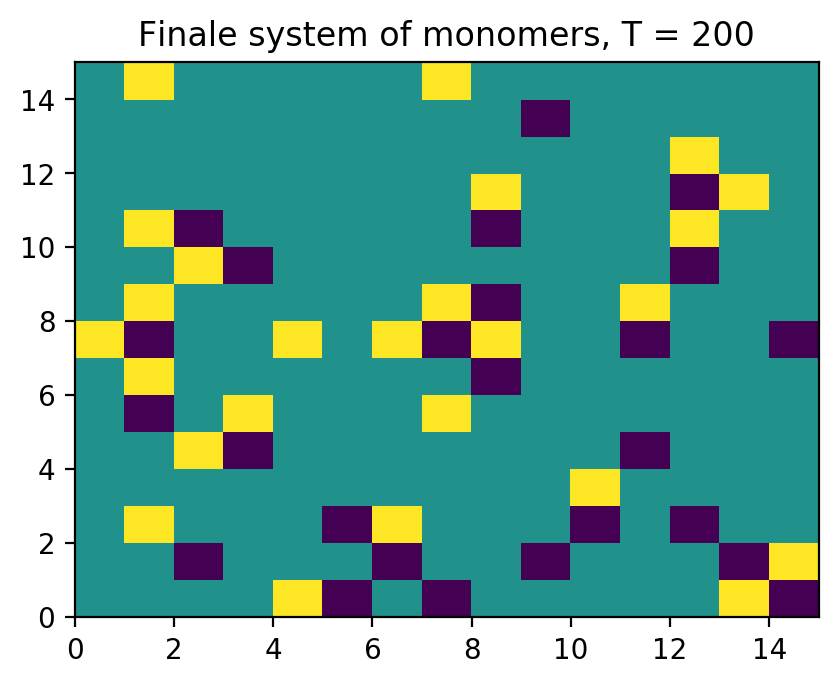

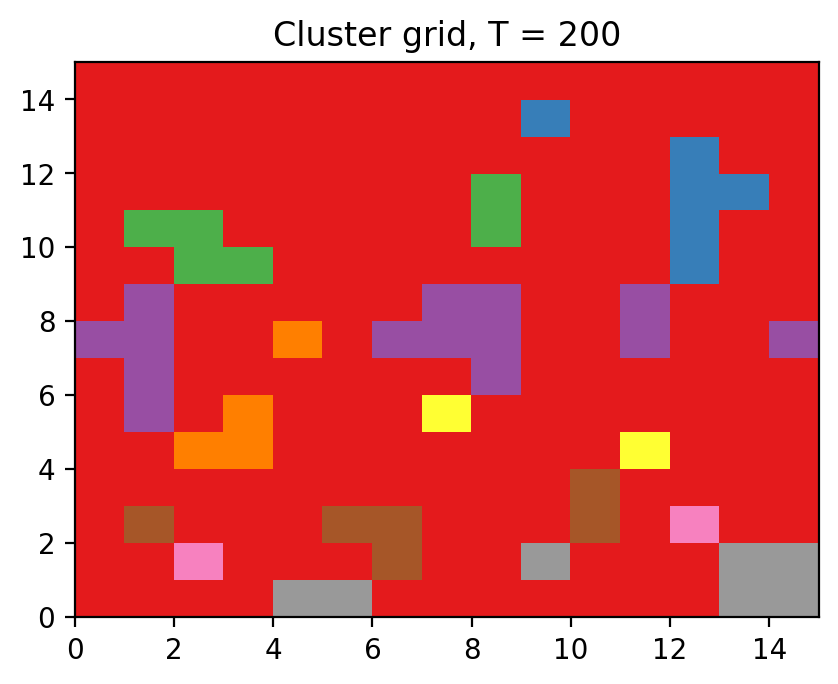

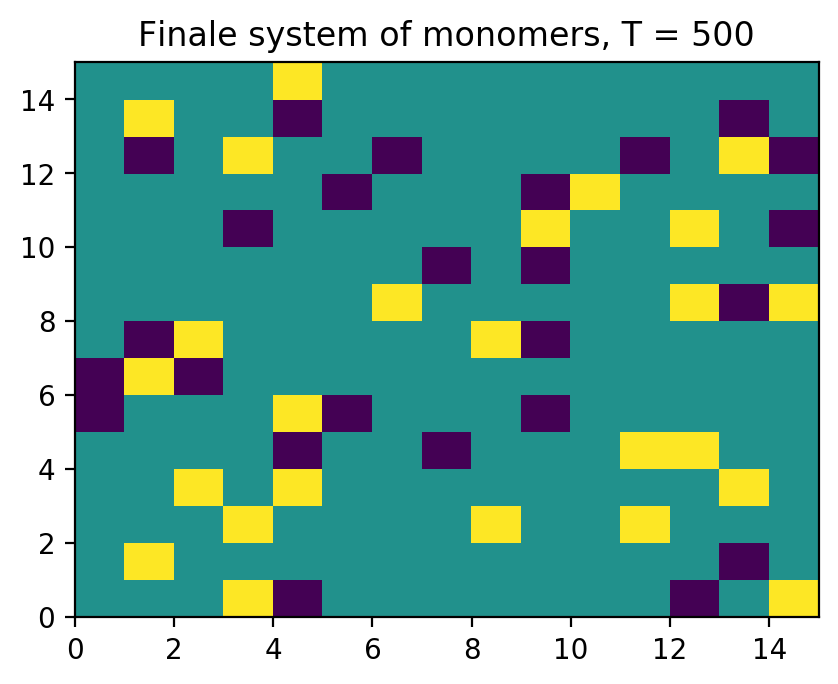

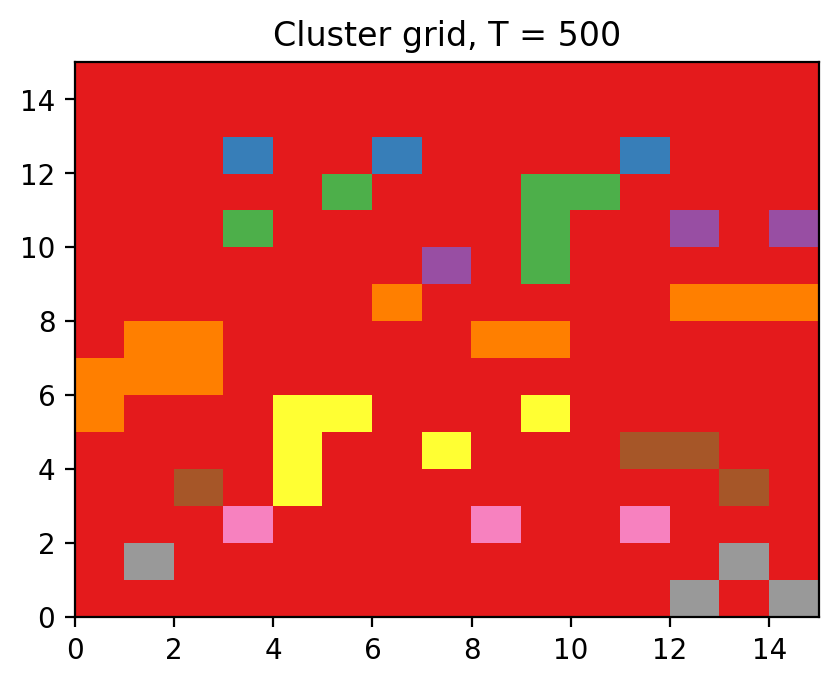

In [8]:
##Oppgave 1f)

def cluster(grid, N):
    locationOfMonomers = np.transpose(np.nonzero(grid))
    
    clusterGrid = np.zeros([N,N])
    monomersLeft = locationOfMonomers.tolist()
    monomersNext = list()
    clusterSize = list()
    
    val = 1

    while len(monomersLeft) > 0:
        
        y0, x0 = monomersLeft[0]
        monomersLeft.remove([y0, x0])
        monomersNext.append([y0, x0])
        size = 0
    
        while len(monomersNext) > 0:
            
            y, x = monomersNext[0]
            clusterGrid[y,x] = val

            monomersNext.remove([y, x])

            right = [y, (x+1)%N]
            if right in monomersLeft:
                monomersLeft.remove(right)
                monomersNext.append(right)

            left = [y, (x-1)%N]
            if left in monomersLeft:
                monomersLeft.remove(left)
                monomersNext.append(left)

            under = [(y+1)%N, x]
            if under in monomersLeft:
                monomersLeft.remove(under)
                monomersNext.append(under)

            above = [(y-1)%N, x]
            if above in monomersLeft:
                monomersLeft.remove(above)
                monomersNext.append(above)
        val += 1
        clusterSize.append(size)

    return clusterGrid

clusterGrid_500 = cluster(grid_500, 15)
clusterGrid_200 = cluster(grid_200, 15)

plotSystemOfMonomers(grid_200, "Finale system of monomers, T = 200")
plotSystemOfMonomers(clusterGrid_200, "Cluster grid, T = 200", cluster = True)

plotSystemOfMonomers(grid_500, "Finale system of monomers, T = 500")
plotSystemOfMonomers(clusterGrid_500, "Cluster grid, T = 500", cluster = True)